# Explore eo-learn package 

In [2]:
# ML libs
import pandas as pd
import numpy as np
from aenum import MultiValueEnum
import geopandas as gpd

import datetime
# File manipulation
import os
from urllib.request import urlopen
import json
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET

# Graphic
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import plotly.express as px
import shapely

# Environment variables
datasets_dir = os.environ.get('DATA_DIR_LOCAL')

In [3]:
one_view_dir = "RPG/S2A_MSIL2A_20240412T105621_N0510_R094_T30TXP_20240412T165247.SAFE"
one_view_path = os.path.join(datasets_dir,one_view_dir)

TypeError: expected str, bytes or os.PathLike object, not NoneType

# Accessing the bounding-box info of the satellite image

In [3]:
one_view_path = os.path.join(one_view_path,os.listdir(one_view_path)[0])

In [4]:
os.listdir(one_view_path)

['DATASTRIP',
 'manifest.safe',
 'S2A_MSIL2A_20240412T105621_N0510_R094_T30TXP_20240412T165247-ql.jpg',
 'rep_info',
 'MTD_MSIL2A.xml:Zone.Identifier',
 'INSPIRE.xml:Zone.Identifier',
 'HTML',
 'S2A_MSIL2A_20240412T105621_N0510_R094_T30TXP_20240412T165247-ql.jpg:Zone.Identifier',
 'MTD_MSIL2A.xml',
 'GRANULE',
 'INSPIRE.xml',
 'manifest.safe:Zone.Identifier']

In [5]:
MTD_MSIL2A_file = os.path.join(one_view_path, 'MTD_MSIL2A.xml')
with open(MTD_MSIL2A_file) as fp:
    MTD_MSIL2A_soup = BeautifulSoup(fp,'xml')

In [6]:
MTD_MSIL2A_coord_list = MTD_MSIL2A_soup.find('EXT_POS_LIST').text.split()

In [7]:
MTD_MSIL2A_coord_list

['44.24655093494868',
 '-1.747519127776807',
 '44.22320974043625',
 '-0.37335402628884',
 '43.235600960154144',
 '-0.416191720419125',
 '43.25815531909012',
 '-1.767967299958169',
 '44.24655093494868',
 '-1.747519127776807']

## Using eo-learn

In [8]:
from shapely.geometry import Polygon

from tqdm.auto import tqdm
import geopandas as gpd

from sentinelhub import DataCollection, UtmZoneSplitter

# Imports from eo-learn and sentinelhub-py
from eolearn.core import (
    EOExecutor,
    EOPatch,
    EOTask,
    EOWorkflow,
    FeatureType,
    LoadTask,
    MergeFeatureTask,
    OverwritePermission,
    SaveTask,
    linearly_connect_tasks,
)
from eolearn.features import NormalizedDifferenceIndexTask, SimpleFilterTask
from eolearn.features.extra.interpolation import LinearInterpolationTask
from eolearn.geometry import ErosionTask, VectorToRasterTask
from eolearn.io import ExportToTiffTask, SentinelHubInputTask, VectorImportTask
from eolearn.ml_tools import FractionSamplingTask

ModuleNotFoundError: No module named 'sklearn'

Dimension of the area is 85431 x 65625 m2


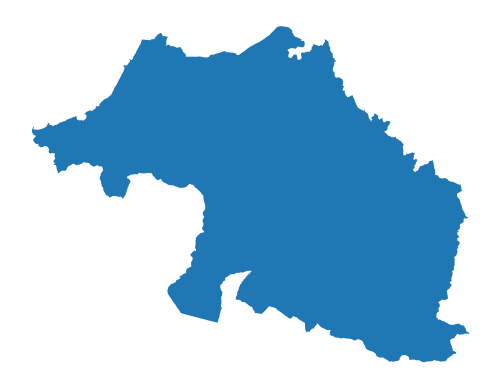

In [387]:
# Folder where data for running the notebook is stored
DATA_FOLDER = os.path.join(datasets_dir, "RPG/PaysBasque")
# Locations for collected data and intermediate results
EOPATCH_FOLDER = os.path.join(".", "eopatches")
EOPATCH_SAMPLES_FOLDER = os.path.join(".", "eopatches_sampled")
RESULTS_FOLDER = os.path.join(".", "results")
for folder in (EOPATCH_FOLDER, EOPATCH_SAMPLES_FOLDER, RESULTS_FOLDER):
    os.makedirs(folder, exist_ok=True)

# Load geojson file
zone_covered = gpd.read_file(os.path.join(DATA_FOLDER, "contour-du-pays-basque.geojson")).to_crs('32630')
# Add 500m buffer to secure sufficient data near border
#zone_covered = zone_covered.buffer(500)

# Get the country's shape in polygon format
zone_covered_shape = zone_covered.geometry.values[0]

# Plot country
zone_covered.plot()
plt.axis("off")

# Print size
zone_covered_width = zone_covered_shape.bounds[2] - zone_covered_shape.bounds[0]
zone_covered_height = zone_covered_shape.bounds[3] - zone_covered_shape.bounds[1]
print(f"Dimension of the area is {zone_covered_width:.0f} x {zone_covered_height:.0f} m2")

In [412]:
# Coordinates format
zone_covered.crs

<Projected CRS: EPSG:32630>
Name: WGS 84 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°W and 0°W, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Burkina Faso. Côte' Ivoire (Ivory Coast). Faroe Islands - offshore. France. Ghana. Gibraltar. Ireland - offshore Irish Sea. Mali. Mauritania. Morocco. Spain. United Kingdom (UK).
- bounds: (-6.0, 0.0, 0.0, 84.0)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [419]:
resolution = 10 # meters per pixel, used for raster dimension and satellite images
patch_dim = 255 # number of pixel

# Create a splitter to obtain a list of bboxes
bbox_splitter = UtmZoneSplitter([zone_covered_shape], zone_covered.crs, patch_dim*resolution)

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs = [info["index"] for info in info_list]
idxs_x = [info["index_x"] for info in info_list]
idxs_y = [info["index_y"] for info in info_list]

bbox_gdf = gpd.GeoDataFrame({"index": idxs, "index_x": idxs_x, "index_y": idxs_y}, crs=zone_covered.crs, geometry=geometry)

# Save to shapefile
shapefile_name = "grid_paysbasque_500x500.gpkg"
bbox_gdf.to_file(os.path.join(RESULTS_FOLDER, shapefile_name), driver="GPKG")

In [420]:
size_surrounding = 1
size_of_selected_area = 2*size_surrounding + 1
# select a 5x5 area (id of center patch)
ID = 27

# Obtain surrounding 5x5 patches
patch_ids = []
for idx, info in enumerate(info_list):
    if abs(info["index_x"] - info_list[ID]["index_x"]) <= size_surrounding and abs(info["index_y"] - info_list[ID]["index_y"]) <= size_surrounding:
        patch_ids.append(idx)

# Check if final size is 5x5
if len(patch_ids) != size_of_selected_area * size_of_selected_area:
    print("Warning! Use a different central patch ID, this one is on the border.")

# Change the order of the patches (useful for plotting)
patch_ids = np.transpose(np.fliplr(np.array(patch_ids).reshape(size_of_selected_area, size_of_selected_area))).ravel()

# Save to shapefile
shapefile_name = "grid_paysbasque_500x500.gpkg"
bbox_gdf.to_file(os.path.join(RESULTS_FOLDER, shapefile_name), driver="GPKG")

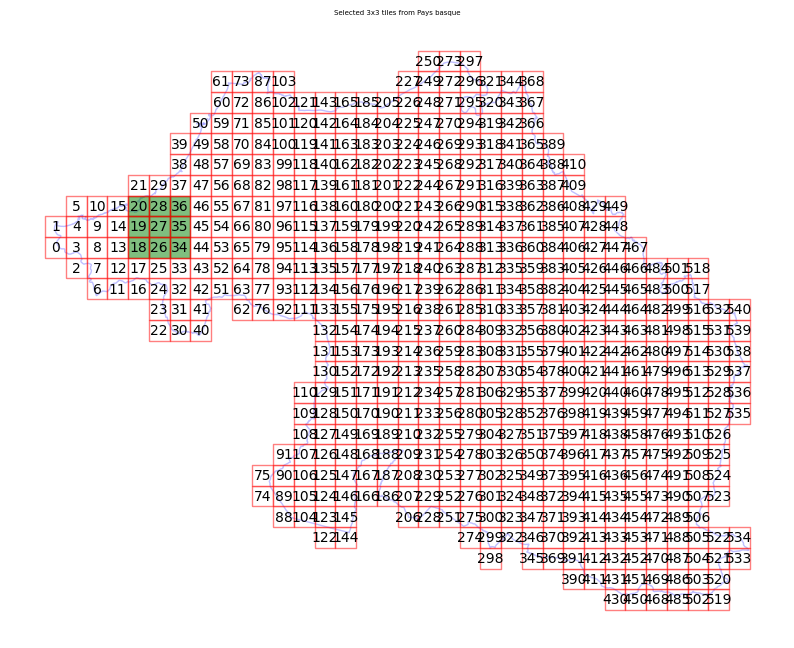

In [421]:
# Display bboxes over country

fig_size = 10
fig, ax = plt.subplots(figsize=(fig_size, fig_size))
ax.set_title(f"Selected {size_of_selected_area}x{size_of_selected_area} tiles from Pays basque", fontsize=0.5*fig_size)
zone_covered.plot(ax=ax, facecolor="w", edgecolor="b", alpha=0.5)
bbox_gdf.plot(ax=ax, facecolor="w", edgecolor="r", alpha=0.5)

for bbox, info in zip(bbox_list, info_list):
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, info["index"], ha="center", va="center")

# Mark bboxes of selected area
bbox_gdf[bbox_gdf.index.isin(patch_ids)].plot(ax=ax, facecolor="g", edgecolor="r", alpha=0.5)

plt.axis("off");

In [422]:
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "BANDS"),
    bands=band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, "dataMask", "IS_DATA"), (FeatureType.MASK, "CLM"), (FeatureType.DATA, "CLP")],
    max_threads=5,
)

### EOTasks definition 

In [423]:
class SentinelHubValidDataTask(EOTask):
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """

    def __init__(self, output_feature):
        self.output_feature = output_feature

    def execute(self, eopatch):
        eopatch[self.output_feature] = eopatch.mask["IS_DATA"].astype(bool) & (~eopatch.mask["CLM"].astype(bool))
        return eopatch


class AddValidCountTask(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """

    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch[FeatureType.MASK_TIMELESS, self.name] = np.count_nonzero(eopatch.mask[self.what], axis=0)
        return eopatch

In [424]:
# BAND DATA
# Add a request for S2 bands.
# Here we also do a simple filter of cloudy scenes (on tile level).
# The s2cloudless masks and probabilities are requested via additional data.
band_names = ["B02", "B03", "B04", "B08", "B11", "B12"]
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "BANDS"),
    bands=band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, "dataMask", "IS_DATA"), (FeatureType.MASK, "CLM"), (FeatureType.DATA, "CLP")],
    max_threads=5,
)


# CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDBI: (B11 - B08)/(B11 + B08)
ndvi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDVI"), [band_names.index("B08"), band_names.index("B04")]
)
ndwi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDWI"), [band_names.index("B03"), band_names.index("B08")]
)
ndbi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDBI"), [band_names.index("B11"), band_names.index("B08")]
)


# VALIDITY MASK
# Validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_validmask = SentinelHubValidDataTask((FeatureType.MASK, "IS_VALID"))

# COUNTING VALID PIXELS
# Count the number of valid observations per pixel using valid data mask
add_valid_count = AddValidCountTask("IS_VALID", "VALID_COUNT")

In [425]:
# SAVING TO OUTPUT (if needed)
save = SaveTask(EOPATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

### Proprocess data

In [426]:
paysbasque_geojson_path = os.path.join(DATA_FOLDER, "rpg-2020-registre-parcellaire-graphique.geojson")
# change coordinates system of input data
paysbasque_geojson = gpd.read_file(paysbasque_geojson_path).to_crs('32630')
paysbasque_geojson.dropna(subset=['grp_cultu'], inplace=True)

In [427]:
# OneHotEncode grp_cultu column in grp_encoded
encode_dict = {name: i for i, name in enumerate(paysbasque_geojson['grp_cultu'].unique())}
paysbasque_geojson['grp_encoded'] = paysbasque_geojson['grp_cultu'].replace(encode_dict)

/tmp/ipykernel_2192016/4279635112.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  paysbasque_geojson['grp_encoded'] = paysbasque_geojson['grp_cultu'].replace(encode_dict)


In [402]:
# Save preprocessed data
paysbasque_geopd_path = os.path.join(DATA_FOLDER, "rpg-2020-modified.geojson")
paysbasque_geojson.to_file(paysbasque_geopd_path)

In [403]:
paysbasque_geojson = gpd.read_file(paysbasque_geopd_path)

In [404]:
paysbasque_geojson.head()

,geo_point_2d,geo_shape,anon_id,millesime,bio,code_cultu,lbl_cultu,grp_cultu,surface_ha,surf_adm,maraichage,agroforest,insee,nom,surf_ha,nom_epci,pole_terri,surface_parcelle_m2,grp_encoded,geometry
0,"{'lon': -1.0722637006190943, 'lat': 43.2002914...",None,19c955509e22f6c0dcd8a8a5e0a6e27f9797c67ef8e7b247,2020,Oui.000,PTR,Autre prairie temporaire de 5 ans ou moins,Prairies temporaires,0.73,0.73,0,0,64150,Bunus,665.0,CA du Pays Basque,Iholdi Oztibarre,7300.0,0,"POLYGON ((656575.594 4784819.582, 656565.588 4..."
1,"{'lon': -1.257895729374897, 'lat': 43.10041427...",None,5c35ec6ae9f796af83283f98770f9bb94f4e1364d855a10b,2020,Non,SPL,Surface pastorale - ressources fourragères lig...,Estives et landes,1.55,1.23,0,0,64047,Arnéguy,2115.0,CA du Pays Basque,Garazi Baigorri,15500.0,1,"POLYGON ((641793.618 4773532.044, 641818.199 4..."
2,"{'lon': -1.2612932240073889, 'lat': 43.0908556...",None,5c35ec6ae9f796af83283f98770f9bb94f4e1364d855a10b,2020,Non,SPL,Surface pastorale - ressources fourragères lig...,Estives et landes,0.83,0.66,0,0,64047,Arnéguy,2115.0,CA du Pays Basque,Garazi Baigorri,8300.0,1,"POLYGON ((641467.880 4772379.827, 641451.736 4..."
3,"{'lon': -1.2608548667251809, 'lat': 43.0906853...",None,5c35ec6ae9f796af83283f98770f9bb94f4e1364d855a10b,2020,Non,SPL,Surface pastorale - ressources fourragères lig...,Estives et landes,0.32,0.00,0,0,64047,Arnéguy,2115.0,CA du Pays Basque,Garazi Baigorri,3200.0,1,"POLYGON ((641483.176 4772312.901, 641489.718 4..."
4,"{'lon': -1.1076413925015816, 'lat': 43.4611995...",None,957b1009c5f9bdedc728e87533aa2c86a5f92a0ac3467bb8,2020,Non,MIS,Maïs,Maïs grain et ensilage,4.00,4.00,0,0,64161,Came,3424.0,CA du Pays Basque,Pays de Bidache,40000.0,2,"POLYGON ((653073.489 4813933.498, 653126.553 4..."


### Create color map for display

In [428]:
grp_cultu_list = list(paysbasque_geojson['grp_encoded'].unique())
cmap = plt.get_cmap('coolwarm', len(grp_cultu_list))
grp_cultu_dict = {}
for i, cultu in enumerate(grp_cultu_list):
    grp_cultu_dict[cultu]={
        "name": cultu,
        "id": i,
        "color": cmap(i)
    }

pb_norm = BoundaryNorm([x - 0.5 for x in range(len(grp_cultu_dict) + 1)], cmap.N)

In [406]:
grp_cultu_list = list(paysbasque_geojson['grp_cultu'].unique())
grp_cultu_list = [cultu.replace(" ", "_").replace("(", "").replace(")", "") for cultu in grp_cultu_list if cultu is not None]
cmap = plt.get_cmap('viridis', len(grp_cultu_list))

RPG_colors_dict ={}

for i, cultu in enumerate(grp_cultu_list):
    RPG_colors_dict[cultu]={"name": cultu,
                            "id": i,
                            "color": list_colors[i]
                           }

# Reference colormap things
RPG_norm = BoundaryNorm([x - 0.5 for x in range(RPG_colors_dict + 1)], cmap.N)

TypeError: unsupported operand type(s) for +: 'dict' and 'int'

In [407]:
vector_feature = FeatureType.VECTOR_TIMELESS, "PB_REFERENCE"

vector_import_task = VectorImportTask(vector_feature, paysbasque_geopd_path)

rasterization_task = VectorToRasterTask(
    vector_feature,
    (FeatureType.MASK_TIMELESS, "pb"),
    values_column="grp_encoded",
    #raster_shape=(FeatureType.MASK, "IS_DATA"),
    raster_resolution=10,
    raster_dtype=np.uint8,
)

In [408]:
paysbasque_geojson = os.path.join(DATA_FOLDER, "rpg-2020-registre-parcellaire-graphique.geojson")
vector_feature = FeatureType.VECTOR_TIMELESS, "RPG_REFERENCE"

vector_import_task = VectorImportTask(vector_feature, paysbasque_geojson)

rasterization_task = VectorToRasterTask(
    vector_feature,
    (FeatureType.MASK_TIMELESS, "RPG_colors_dict"),
    values_column="grp_cultu",
    #raster_shape=(FeatureType.MASK, "IS_DATA"),
    raster_resolution=10,
    raster_dtype=np.uint8,
)
# SAVING TO OUTPUT (if needed)
save = SaveTask(EOPATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

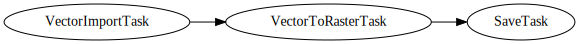

In [295]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(
    vector_import_task, rasterization_task, save
)
workflow = EOWorkflow(workflow_nodes)

# Let's visualize it
workflow.dependency_graph()

In [209]:
# Define additional parameters of the workflow
input_node = workflow_nodes[0]
save_node = workflow_nodes[-1]
execution_args = []
for idx, bbox in enumerate(bbox_list[patch_ids]):
    execution_args.append(
        {
            input_node: {"bbox": bbox},
            save_node: {"eopatch_folder": f"eopatch_{idx}"},
        }
    )

# Execute the workflow
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=4)

executor.make_report()

  0%|          | 0/9 [00:00<?, ?it/s]

/home/ken/.pyenv/versions/3.12.3/envs/satellite-crops/lib/python3.12/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)
/home/ken/.pyenv/versions/3.12.3/envs/satellite-crops/lib/python3.12/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)
/home/ken/.pyenv/versions/3.12.3/envs/satellite-crops/lib/python3.12/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) 

  0%|          | 0/9 [00:00<?, ?it/s]

CreateFailed: root path '/home/ken/code/Ken4git/satellite-crops/eopatches/eopatch_0' does not exist

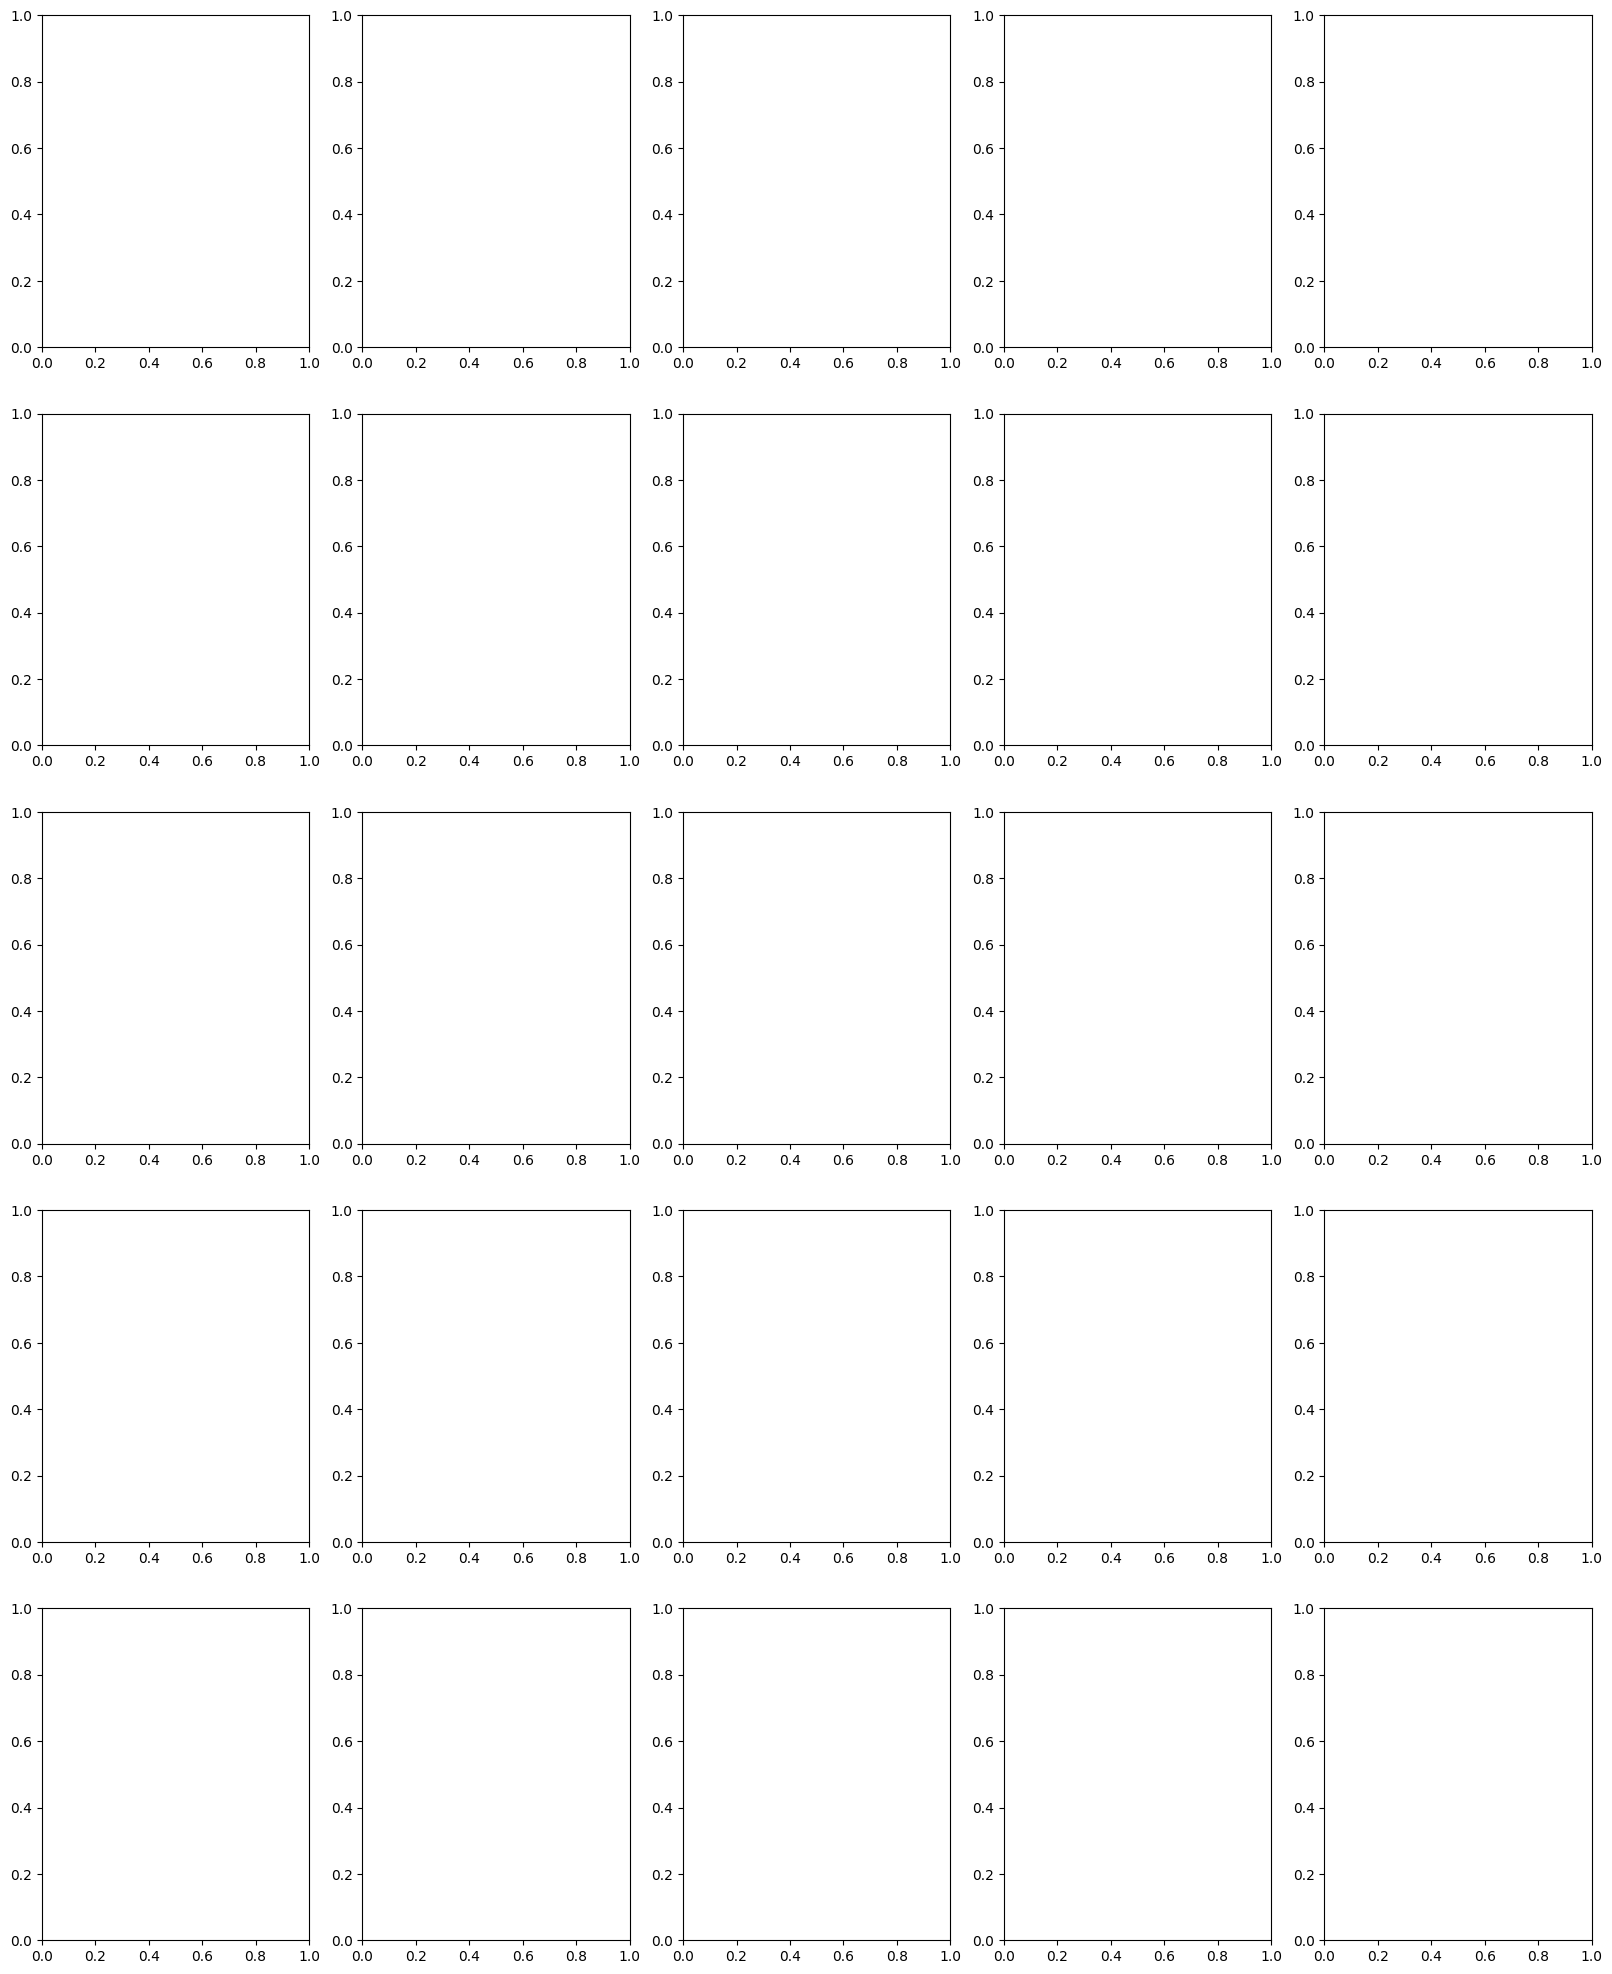

In [210]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))

for i in tqdm(range(len(patch_ids))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    ax = axs[i // 5][i % 5]
    im = ax.imshow(eopatch.mask_timeless["RPG_colors_dict"].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.name for entry in LULC], rotation=45, fontsize=15)
plt.show();

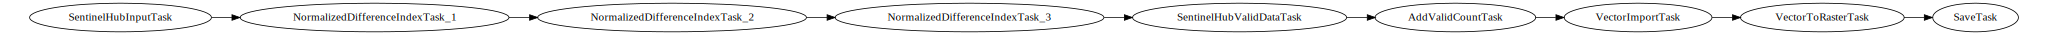

In [409]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(
   vector_import_task, rasterization_task, save
  # add_data, ndvi, ndwi, ndbi, add_sh_validmask, add_valid_count, vector_import_task, rasterization_task, save

)
workflow = EOWorkflow(workflow_nodes)

# Let's visualize it
workflow.dependency_graph()

In [411]:
%%time

# Time interval for the SH request
time_interval = ["2019-01-01", "2019-12-31"]

# Define additional parameters of the workflow
input_node = workflow_nodes[0]
save_node = workflow_nodes[-1]
execution_args = []
for idx, bbox in enumerate(bbox_list[patch_ids]):
    execution_args.append(
        {
            input_node: {"bbox": bbox},
            save_node: {"eopatch_folder": f"eopatch_{idx}"},
        }
    )


# Execute the workflow
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=4)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

  0%|          | 0/9 [00:00<?, ?it/s]

/home/ken/.pyenv/versions/3.12.3/envs/satellite-crops/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ken/.pyenv/versions/3.12.3/envs/satellite-crops/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ken/.pyenv/versions/3.12.3/envs/satellite-crops/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ken/.pyenv/versions/3.12.3/envs/satellite-crops/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ken/.pyenv

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

  0%|          | 0/9 [00:00<?, ?it/s]

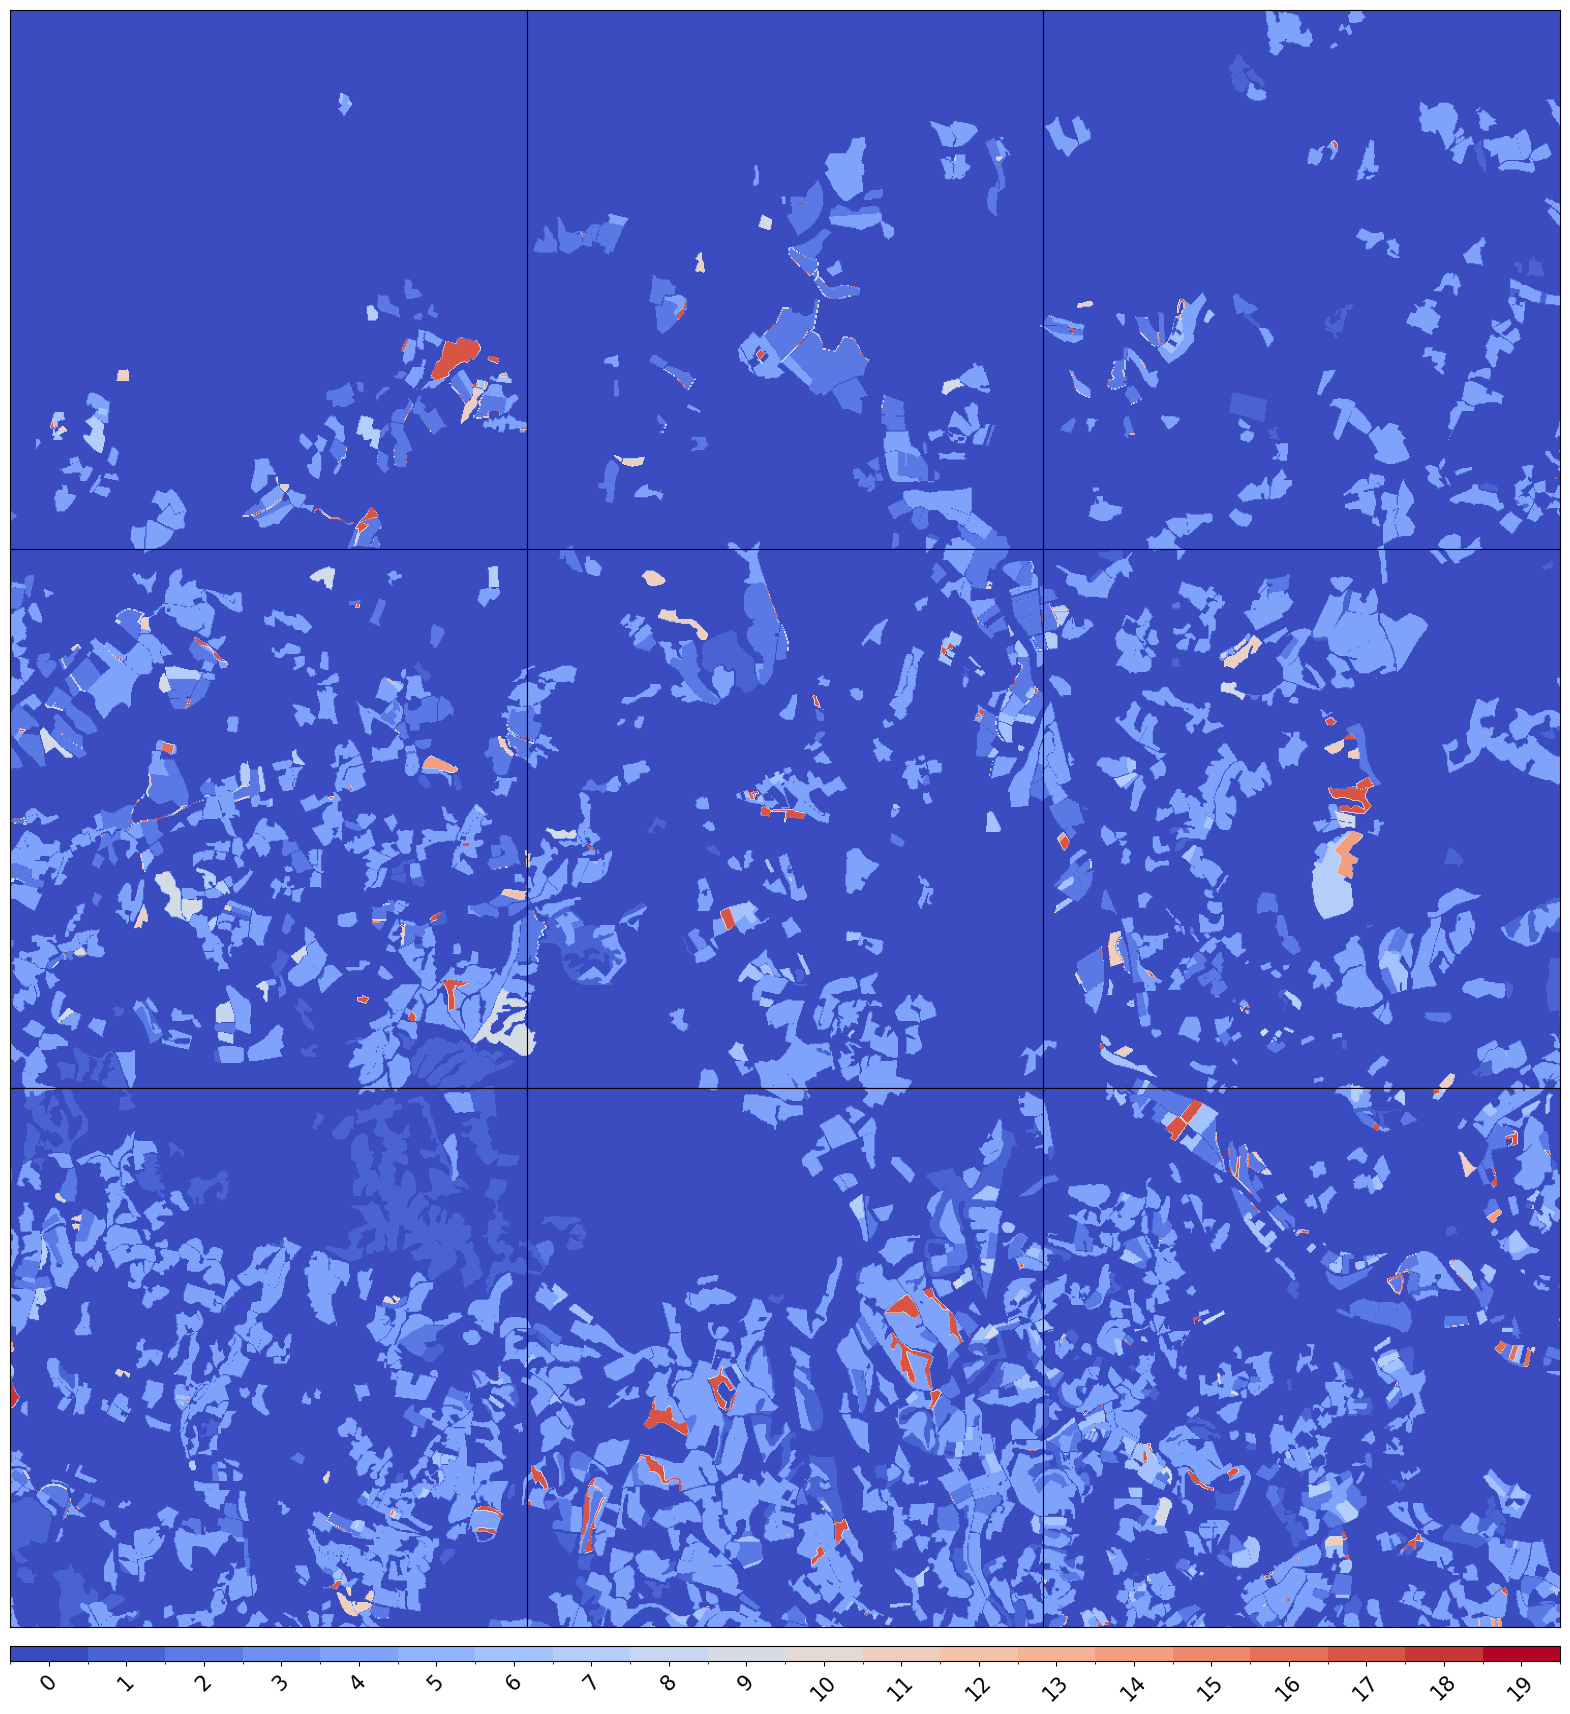

In [386]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 25))

for i in tqdm(range(len(patch_ids))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    ax = axs[i // 3][i % 3]
    im = ax.imshow(eopatch.mask_timeless["pb"].squeeze(), cmap=cmap, norm=pb_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([grp_cultu_dict[key]['id'] for key in grp_cultu_dict.keys()])
cb.ax.set_xticklabels([grp_cultu_dict[key]['name'] for key in grp_cultu_dict.keys()], rotation=45, fontsize=15)
plt.show();